In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
from scipy.optimize import minimize

Parameter Estimation

In [2]:
stock = yf.Ticker('NVDA')
mat = ql.Date(stock.options[10],'yyyy-mm-dd')
strike = stock.option_chain(stock.options[10]).calls['strike']
price = stock.option_chain(stock.options[10]).calls['lastPrice']
price.index = strike
price = price[price.index<400]
strike = strike[strike<400]
spot = stock.info.get("regularMarketPrice")
r = 0.05
q = 0.04/spot

Quantlib Pricing

In [3]:
def Heston_priceql(Theta, args):
    K, maturity_date, r, S0 = args
    v0, kappa, theta, sigma, rho = Theta

    today = ql.Date.todaysDate()
    day_count = ql.Actual365Fixed()

    risk_free = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
    dividend = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))
    spot = ql.QuoteHandle(ql.SimpleQuote(S0))
    
    heston_process = ql.HestonProcess(risk_free, dividend, spot, v0, kappa, theta, sigma, rho)
    heston_model = ql.HestonModel(heston_process)
    
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    exercise = ql.EuropeanExercise(maturity_date)
    
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticHestonEngine(heston_model))
    price = option.NPV()
    return price

## Loss Function

def Loss(Theta,args):
    prices, Ks, maturity_date, r, S0=args
    loss = 0
    prices.index = Ks
    for K in Ks:
        args_1 = [K, maturity_date, r, S0]
        loss = loss + (np.abs(prices[K]-Heston_priceql(Theta,args_1)))/len(Ks)
    return loss

Estimating parameters based on the loss function

In [4]:
bounds = [(1e-8,None),(1e-8,None),(1e-8,None),(1e-8,None),(-1,1)]
Theta_0 = [1,2,0.5,1,-0.5]

result = minimize(Loss, Theta_0, [price, strike, mat, r, spot], bounds = bounds)

In [5]:
result.x

array([ 1.00000000e-08,  2.65388951e+00,  4.32058008e-01,  8.86691106e-01,
       -2.40877248e-01])

Calculating Heston prices

In [6]:
Heston_prices = []
for K in strike:
    Heston_prices.append(Heston_priceql(result.x,[K, mat, r, spot]))

Heston_prices = pd.Series(Heston_prices, index = strike)

Plotting Heston Prices

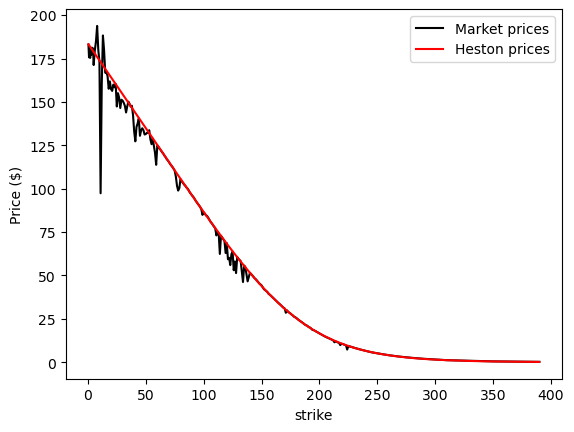

In [22]:
price.plot(color = 'black', label = 'Market prices')
pd.Series(Heston_prices).plot(color= "red", label = "Heston prices")
plt.legend()
plt.ylabel('Price ($)')
plt.savefig('Price_Strike.pdf')
plt.show()

In [8]:
## Implied Volatility

def implied_vol(args):
    price, K, maturity_date, r, S0 = args

    today = ql.Date.todaysDate()
    day_count = ql.Actual365Fixed()
    time_to_maturity = day_count.yearFraction(today, maturity_date)

    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
    risk_free = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
    dividend = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))
    spot = ql.QuoteHandle(ql.SimpleQuote(S0))
    volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, 0.20, day_count))
    
    bsm_process = ql.BlackScholesMertonProcess(spot, dividend, risk_free, volatility)
    
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    exercise = ql.EuropeanExercise(maturity_date)
    
    # Calculate present value of strike
    pv_strike = K * risk_free.discount(time_to_maturity)

    # Theoretical Maximum: C_max = S0 * exp(-q*T)
    max_price = S0 * dividend.discount(time_to_maturity)
    # Theoretical Minimum: C_min = max(0, S0 * exp(-q*T) - K * exp(-r*T))
    min_price = max(0.0, S0 * dividend.discount(time_to_maturity) - pv_strike)

    # Add a small tolerance for floating point comparison
    tolerance = 1e-6

    if price > max_price + tolerance:
        return float('nan')

    if price < min_price - tolerance:
        return float('nan')

    else :
        option = ql.VanillaOption(payoff, exercise)
        imp_vol = option.impliedVolatility(price, bsm_process,1.0e-4,100,1.0e-05,5)
        return imp_vol

Calculating time series of Implied vols of Heston prices

In [9]:
Implied_vol_H = []
for K in strike:
    Implied_vol_H.append(implied_vol([Heston_prices[K],K, mat, r, spot]))

Implied_vol_H = pd.Series(Implied_vol_H, index = strike)
Implied_vol_H = Implied_vol_H.dropna()

Implied_vol = []
for K in strike:
    IV = implied_vol([price[K],K, mat, r, spot])
    Implied_vol.append(IV)
Implied_vol = pd.Series(Implied_vol, index = strike)
Implied_vol = Implied_vol.dropna()

BS pricing

In [12]:
def BS_priceql(Theta, args):
    K, maturity_date, r, S0 = args
    sigma = Theta[0]

    today = ql.Date.todaysDate()
    day_count = ql.Actual365Fixed()

    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
    risk_free = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
    spot = ql.QuoteHandle(ql.SimpleQuote(S0))
    volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, day_count))
    
    bsm_process = ql.BlackScholesProcess(spot, risk_free, volatility)
    
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    exercise = ql.EuropeanExercise(maturity_date)
    
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    price = option.NPV()
    return price

## Loss Function

def Loss_BS(Theta,args):
    prices, Ks, maturity_date, r, S0=args
    loss = 0
    prices.index = Ks
    for K in Ks:
        args_1 = [K, maturity_date, r, S0]
        loss = loss + (np.abs(prices[K]-BS_priceql(Theta,args_1)))/len(Ks)
    return loss

Estimating BS parameters

In [13]:
bounds_BS = [(1e-8, None)]
Theta_0_BS = 0.2

result_BS = minimize(Loss_BS, Theta_0_BS, [price, strike, mat, r, spot], bounds = bounds_BS)

Making a plottable time series for the BS implied vol

In [14]:
BS_implied_vol = []
for K in strike:
    BS_implied_vol.append(result_BS.x[0])
BS_implied_vol = pd.Series(BS_implied_vol, index = strike)

Plotting BS vs Heston vs Actual implied vol

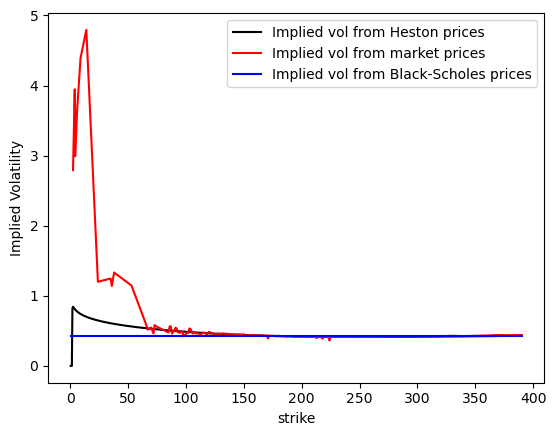

In [23]:
Implied_vol_H.plot(color = 'black', label = 'Implied vol from Heston prices')
Implied_vol.plot(color = 'red', label = 'Implied vol from market prices')
BS_implied_vol.plot(color = 'blue', label = 'Implied vol from Black-Scholes prices')
plt.legend()
plt.ylabel('Implied Volatility')
plt.savefig('Volatility_Strike.pdf')
plt.show()

In [16]:
BS_prices = []
for K in strike:
    BS_prices.append(BS_priceql(result_BS.x,[K, mat, r, spot]))

BS_prices = pd.Series(BS_prices, index = strike)

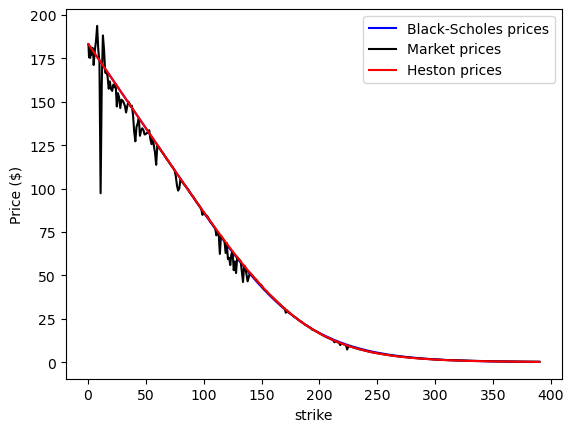

In [17]:
BS_prices.plot(color = 'blue', label = 'Black-Scholes prices')
price.plot(color = 'black', label = 'Market prices')
pd.Series(Heston_prices).plot(color= "red", label = "Heston prices")
plt.legend()
plt.ylabel('Price ($)')
plt.show()

Plotting Delta function

In [18]:
Theta = result.x
def Delta(K,T):
    epsilon = 1e-8
    today = ql.Date.todaysDate()
    maturity_date = today + int(T * 365)
    
    args_up = [K, maturity_date, r, spot+epsilon]
    args_down = [K, maturity_date, r,spot-epsilon]
    
    price_up = Heston_priceql(Theta, args_up)
    price_down = Heston_priceql(Theta, args_down)
    
    delta = (price_up-price_down)/(2*epsilon)
    return delta

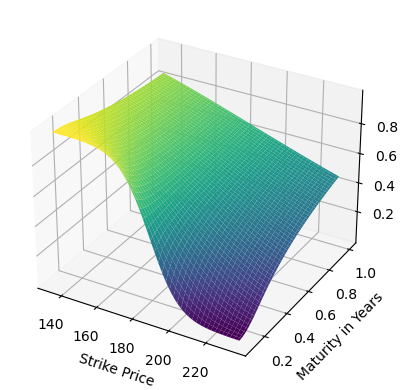

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Create grid
Y = np.linspace(0.1, 1, 100) # maturity
X = np.linspace(spot-50, spot+50, 100) # strike
X, Y = np.meshgrid(X, Y)
Z = np.vectorize(Delta)(X,Y)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity in Years')
ax.set_zlabel('Delta_C')

plt.savefig('Delta.pdf')
plt.show()